In [1]:
from code.cleaner import preprocess

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA

In [3]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')

In [4]:
#changing column names and dropping the one null entry in tweet_text
sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.drop(axis=1, columns=['emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product'], inplace=True)

sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [6]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [7]:
tokenizer = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")

stopwords_list = stopwords.words('english')

specific_words = ['@mention','link','sxsw','#sxsw','@sxsw', 'google',
                 'iphone', 'ipad', 'android', 'app', 'rt', 'apple', 'quot',
                 'store', 'new', '#ipad', 'one']

stopwords_list.extend(specific_words)

lemmer = WordNetLemmatizer()

In [8]:
def preprocess_text(text, tokenizer, stopwords_list, lemmer):
    # Standardize case (lowercase the text)
    lower_t = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lower_t)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [token for token in tokens if token not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    
    
    # Return the preprocessed text
    return lems


text_data = sentiments.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmer))



In [9]:
data = sentiments.copy()

data['preprocessed_text'] = text_data

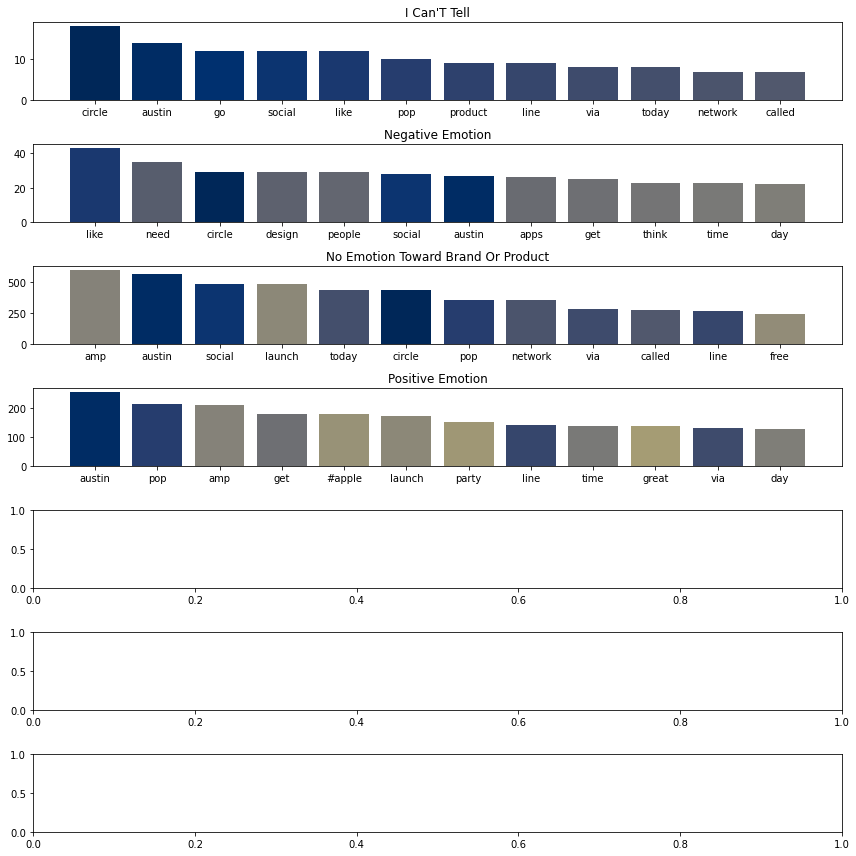

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique sentiment
data_by_sentiment = [y for _, y in data.groupby('sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_tweet = sentiment_df.preprocessed_text.explode()
    top_10 = all_words_in_tweet.value_counts()[:12]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].sentiment.title())
    
fig.tight_layout()